## Importing Libraries

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback



In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Preprocessing - Final Stage

In [4]:
data_dir = "./Data/genres_original/"
classes = os.listdir(data_dir)

In [6]:
from tensorflow.image import resize
from tensorflow.keras import backend as K
import gc
#loading the audio files
def load_and_preprocess_data(data_dir, classes, target_shape=(256, 256)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing class: ", class_name)
        for file in os.listdir(class_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(class_dir, file)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                #Performing Preprocessing
                chunk_duration = 4
                overlap_duration = 2

                #calculate the number of samples in the chunk
                chunk_samples = int(chunk_duration * sample_rate)

                #calculate the number of samples to overlap
                overlap_samples = int(overlap_duration * sample_rate)

                # calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples)) + 1)

                #iterate over the chunks and extract them
                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    #extract the chunk
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    #Resizing the Matrix to the target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #return the data and labels as numpy arrays
    return np.array(data), np.array(labels)

In [8]:
data, labels = load_and_preprocess_data(data_dir, classes)

Processing class:  blues
Processing class:  classical
Processing class:  country
Processing class:  disco
Processing class:  hiphop
Processing class:  jazz
Processing class:  metal
Processing class:  pop
Processing class:  reggae
Processing class:  rock


In [9]:
data.shape

(14975, 256, 256, 1)

In [10]:
data[1, 1]


array([[  0.3077432 ],
       [  0.46545842],
       [  0.59274685],
       [  0.5141609 ],
       [  0.43777406],
       [  0.43942085],
       [  0.6051142 ],
       [  0.9645021 ],
       [  4.9830294 ],
       [ 15.406191  ],
       [ 40.24829   ],
       [ 55.22972   ],
       [ 52.64004   ],
       [ 29.761534  ],
       [ 12.39211   ],
       [  4.138238  ],
       [  3.138879  ],
       [  2.7739482 ],
       [  2.7830305 ],
       [  1.9494569 ],
       [  1.4558203 ],
       [  1.28394   ],
       [  1.3739665 ],
       [  1.3383815 ],
       [  1.2415677 ],
       [  1.5386982 ],
       [  1.6467667 ],
       [  1.6036918 ],
       [  1.3688638 ],
       [  1.3794706 ],
       [  1.4199554 ],
       [  0.9255539 ],
       [  0.5698247 ],
       [  0.35551125],
       [  0.4419094 ],
       [  0.87105536],
       [  1.329225  ],
       [  1.4781809 ],
       [  2.477612  ],
       [  7.3565536 ],
       [ 21.266098  ],
       [ 36.92325   ],
       [ 45.0801    ],
       [ 36

In [11]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes=len(classes))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
labels.shape

(14975, 10)

## Splitting the Dataset for testing and training

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [14]:
X_train.shape


(11980, 256, 256, 1)

## CNN Model

In [15]:
model = tf.keras.models.Sequential()

In [16]:
model.add((Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)))
model.add((Conv2D(filters=32, kernel_size=3, activation='relu')))
model.add((MaxPooling2D(pool_size=2, strides=2)))

In [17]:
model.add((Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)))
model.add((Conv2D(filters=64, kernel_size=3, activation='relu')))
model.add((MaxPooling2D(pool_size=2, strides=2)))

In [18]:
model.add((Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)))
model.add((Conv2D(filters=128, kernel_size=3, activation='relu')))
model.add((MaxPooling2D(pool_size=2, strides=2)))

In [19]:
model.add(Dropout(0.3))

In [20]:
model.add((Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)))
model.add((Conv2D(filters=256, kernel_size=3, activation='relu')))
model.add((MaxPooling2D(pool_size=2, strides=2)))

In [21]:
model.add((Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)))
model.add((Conv2D(filters=512, kernel_size=3, activation='relu')))
model.add((MaxPooling2D(pool_size=2, strides=2)))

In [22]:
model.add(Dropout(0.3))

In [23]:
model.add(Flatten())

In [24]:
model.add(Dense(1200, activation='relu'))


In [25]:
model.add(Dropout(0.45))

In [26]:
#Output Layer
model.add(Dense(units=len(classes), activation='softmax'))


In [27]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [28]:
#Compiling the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# #Training the Model
# class SaveBestHighValAcc(Callback):
#     def __init__(self, filepath):
#         super(SaveBestHighValAcc, self).__init__()
#         self.best_val_acc = 0
#         self.filepath = filepath

#     def on_epoch_end(self, epoch, logs=None):
#         val_acc = logs.get("val_accuracy")
#         if val_acc is not None:
#             if val_acc > self.best_val_acc and val_acc > 0.90:
#                 self.best_val_acc = val_acc
#                 self.model.save(self.filepath)
#                 print(f"\n✅ Saved model at epoch {epoch + 1} with val_accuracy = {val_acc:.4f}")

# # Attach the callback
# save_callback = SaveBestHighValAcc("Trained_Model.h5")

training_history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, Y_test),
    # callbacks=[save_callback]
)


In [26]:
training_history.history


{'loss': [1.8089581727981567,
  1.2696096897125244,
  0.9302084445953369,
  0.7458846569061279,
  0.5608744621276855,
  0.44785580039024353,
  0.36933740973472595,
  0.2909510135650635,
  0.226390078663826,
  0.19857314229011536,
  0.16376204788684845,
  0.1320676952600479,
  0.11792512983083725,
  0.12074233591556549,
  0.08747440576553345,
  0.07954997569322586,
  0.0722273662686348,
  0.0643719881772995,
  0.0571240670979023,
  0.06642725318670273,
  0.0559740774333477,
  0.06411441415548325,
  0.033489130437374115,
  0.04007868096232414,
  0.06641067564487457,
  0.037705760449171066,
  0.02266586944460869,
  0.0473894439637661,
  0.044723402708768845,
  0.03767934814095497],
 'accuracy': [0.34958264231681824,
  0.5581802725791931,
  0.6823872923851013,
  0.7459933161735535,
  0.8108513951301575,
  0.8449081778526306,
  0.8732888102531433,
  0.9007512331008911,
  0.9212020039558411,
  0.9328881502151489,
  0.9457429051399231,
  0.9570951461791992,
  0.9611018300056458,
  0.959015011

In [24]:
import json
with open("training_history.json", "w") as f:
    json.dump(training_history.history, f)

NameError: name 'training_history' is not defined

In [25]:
#Model Loading
model = tf.keras.models.load_model("Trained_Model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                    

In [26]:
import json
with open("training_history.json", "r") as f:
    training_history_data = json.load(f)
training_history_data.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Model Evaluation

In [27]:
#Model Evaluation on Training Data
train_loss, train_accuracy = model.evaluate(X_train, Y_train)

375/375 [==============================] - 21s 46ms/step - loss: 2.3697 - accuracy: 0.1020


In [29]:
#Model Evaluation on Validation Data
val_loss, val_accuracy = model.evaluate(X_test, Y_test)


94/94 [==============================] - 45s 57ms/step - loss: 0.2360 - accuracy: 0.9352


## Accuracy and Loss Visualization


<function matplotlib.pyplot.show(close=None, block=None)>

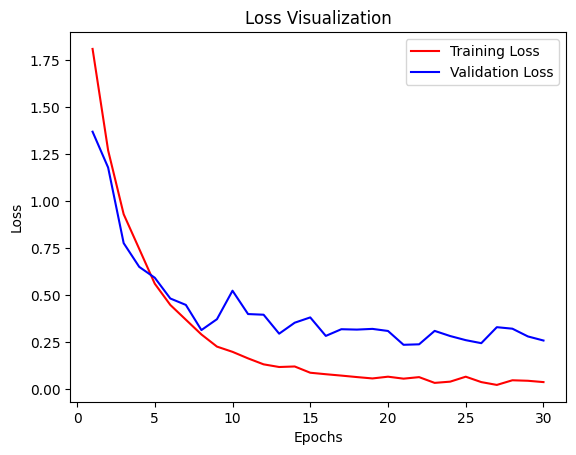

In [29]:
#loss plot
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history_data['loss'], label='Training Loss', color='red')
plt.plot(epochs, training_history_data['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Visualization')
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

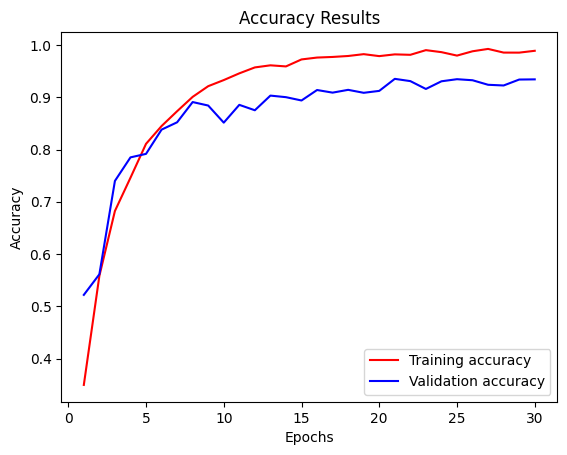

In [27]:
#Visualizing Accuracy
#loss plot
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history_data['accuracy'], label='Training accuracy', color='red')
plt.plot(epochs, training_history_data['val_accuracy'], label='Validation accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Results')
plt.legend()
plt.show



## Precision, Recall, and Confusion Matrix: Further Evaluation


In [30]:
X_test.shape

(2995, 256, 256, 1)

In [31]:
y_pred = model.predict(X_test)
y_pred


94/94 [==============================] - 4s 41ms/step


array([[8.9621777e-03, 1.8131819e-05, 5.9299741e-02, ..., 8.8150656e-01,
        1.8851600e-04, 8.2420111e-03],
       [8.5992536e-24, 2.0663560e-33, 6.8940340e-30, ..., 5.5638243e-30,
        2.4650192e-21, 1.1197894e-14],
       [1.5673562e-15, 3.2565107e-15, 6.9021872e-16, ..., 2.8916712e-18,
        9.2706954e-18, 1.5288647e-07],
       ...,
       [9.9875855e-01, 2.6196286e-16, 2.6930779e-06, ..., 5.7047871e-19,
        8.4628830e-08, 1.1176208e-03],
       [1.4143834e-03, 9.6242857e-01, 2.4560399e-03, ..., 2.2360205e-03,
        3.0025323e-03, 1.5945728e-03],
       [9.5959329e-10, 1.2656894e-10, 1.5558704e-04, ..., 5.6274599e-05,
        6.9757475e-04, 1.7780760e-05]], dtype=float32)

In [32]:
y_pred.shape

(2995, 10)

In [33]:
predicted_categories = np.argmax(y_pred, axis=1)
predicted_categories


array([7, 6, 6, ..., 0, 1, 4], dtype=int64)

In [34]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
true_categories = np.argmax(Y_test, axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4], dtype=int64)

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(true_categories, predicted_categories)

## Confusion Matrix Graph

<function matplotlib.pyplot.show(close=None, block=None)>

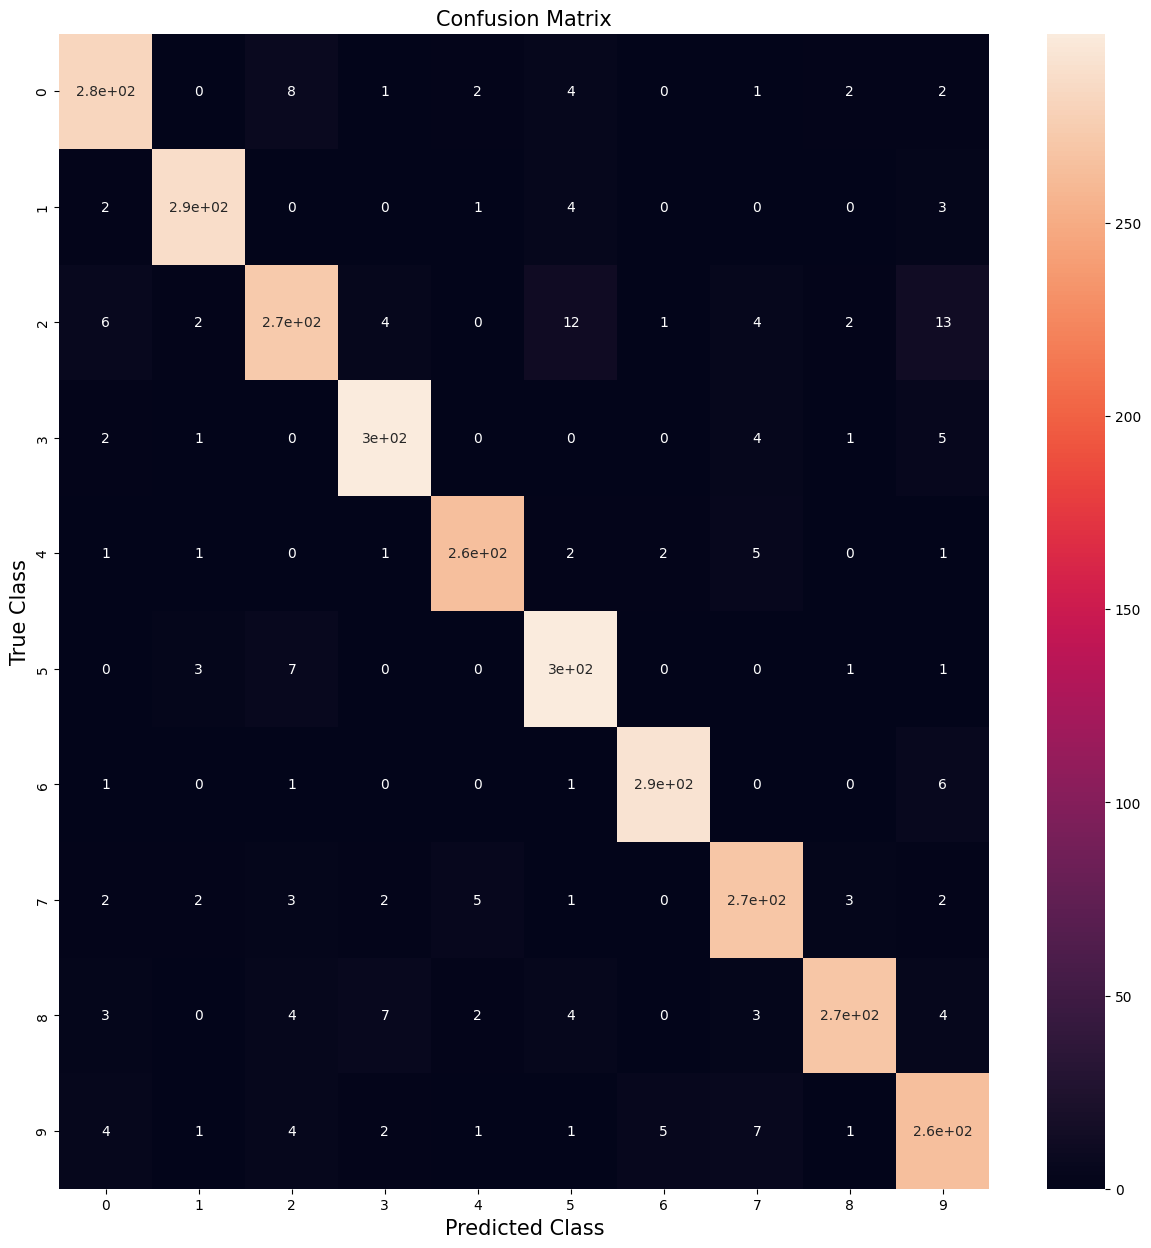

In [37]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, annot_kws={'size': 10})
plt.xlabel('Predicted Class' , fontsize=15)
plt.ylabel('True Class' , fontsize=15)
plt.title('Confusion Matrix' , fontsize=15)
plt.show